## haMSM for Eg5-ADP WT Unbinding WE simulation Data
---
Using CA pairwise distances of Eg5 18-364.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import tqdm.auto

In [2]:
pwd

'/ix/lchong/dty7/eg5/h2p-we/multi-mab_nomon_v01/haMSM'

In [3]:
from msm_we import msm_we
import mdtraj as md

In [4]:
import ray
ray.init(num_cpus=8)
#ray.init()

2023-06-20 12:45:22,151	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.11
Ray version:,2.4.0
Dashboard:,http://127.0.0.1:8265


In [5]:
#ray.shutdown()

Model Name

In [13]:
model_name = 'Eg5_WT_CA_18-364'

In [6]:
import logging
from rich.logging import RichHandler
log = logging.getLogger()
log.addHandler(RichHandler())

msm_log = logging.getLogger("msm_we.msm_we")

In [7]:
def processCoordinates(self, coords):
    log.debug("Processing coordinates")

    if self.dimReduceMethod == "none":
        xt = md.Trajectory(xyz=coords, topology=None)
        indCA = self.reference_structure.topology.select("name CA")
        indAlign = self.reference_structure.topology.select("name CA")
        x2 = xt.superpose(self.reference_structure,atom_indices=indAlign)
        coords = x2._xyz.astype('float64')
        nA = np.shape(indCA)[0]
        nC = np.shape(coords)[0]
        new_coords = coords[:,tuple(indCA),:]
        #new_coords = numpy.double(new_coords)
        #new_coords = coords[:, :923, :]
        data = new_coords.reshape(nC, 3 * nA)
        model.nAtoms = nA
        return data

    if self.dimReduceMethod == "pca" or self.dimReduceMethod == "vamp":

        # Dimensionality reduction
        
        xt = md.Trajectory(xyz=coords, topology=None)
        # ADP heavy atoms
        #indADP = self.reference_structure.topology.select("not type H and resid 370")
        # CA atoms of loop 5
        #indCA = self.reference_structure.topology.select("name CA and resid 116 to 133")
        # CA atoms of Eg5 (non-flexible termini)
        indCA = self.reference_structure.topology.select("name CA and resid 18 to 364")
        # calc distance matrix
        #pair1, pair2 = np.meshgrid(indADP, indCA, indexing="xy")
        pair1, pair2 = np.meshgrid(indCA, indCA, indexing="xy")
        indUT = np.where(np.triu(pair1, k=1) > 0)
        pairs = np.transpose(np.array([pair1[indUT], pair2[indUT]])).astype(int)
        dist = md.compute_distances(xt, pairs, periodic=True, opt=True)

        return dist

# Monkey-patch, i.e. replace the placeholder processCoordinates method in msm_we.modelWE
msm_we.modelWE.processCoordinates = processCoordinates

### Building block-wise haMSM
---

In [9]:
cat ../tstate.file

unbound 12 1 6.1 6.1


Create the model object and initialize it

In [14]:
model =  msm_we.modelWE()
model.initialize(
    fileSpecifier=['west-packopt.h5'], 
    refPDBfile = 'eg5_2022_dry.pdb',
    modelName = model_name,
    basis_pcoord_bounds  = [[0,10], [100,np.inf], [0,6], [0,6]],
    target_pcoord_bounds = [[12,np.inf], [-np.inf,100], [6,np.inf], [6,np.inf]],
    dim_reduce_method = 'pca',
    tau = 50e-12,
    pcoord_ndim = 4,
)

Load all coords and pcoords up to the last iteration you want to use for analysis with

In [15]:
model.get_iterations()
# use up to n last_iter iterations
model.get_coordSet(last_iter=580, streaming=True)

Output()

Prepare dimensionality reduction transformer by running

In [16]:
model.dimReduce()

Output()

In [7]:
# For loading the clustered model data
from pickle import load
with open(f'{model_name}_postPCA.pickle', 'rb') as f:
    model = load(f)

In [17]:
# For saving the clustered model data
from pickle import dump
with open(f'{model_name}_postPCA.pickle', 'wb') as f:
    dump(model, f)

Get WE bin mapper for cluster stratification

In [18]:
import westpa
from westpa.core.binning import RectilinearBinMapper

# 1) ADP-Mg RMSD
# 2) ADP-Mg and Eg5 IntEne
# 3) ADP and Eg5 min dist
# 4) ADP-PO4 and Eg5 min dist
new_mapper = RectilinearBinMapper([[0, 5, 7, 9, 11, 13, 15, 
                                    17, 19, 22, 26, 30, 35, np.inf],
                                   [-np.inf, -125, -75, -25, 
                                    25, 75, 125, 175, 225, 275, np.inf],
                                   [0, 3, 6, np.inf],
                                   [0, 6, np.inf],
                                  ])

Cluster and store original clustering

In [19]:
model.cluster_coordinates(n_clusters = 10, 
                          stratified = True,
                          tol = 1e-5, 
                          streaming = True, 
                          use_ray = True, 
                          first_cluster_iter = 400,
                          user_bin_mapper = new_mapper, 
                          store_validation_model = True)

[06/20/23 14:38:17] INFO     Be aware: Number of cluster centers is an important parameter, and  ]8;id=260731;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=60515;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#160\160]8;;\
                             can drastically affect model quality. We recommend examining                          
                             block-validation results with a range of numbers of clusters, to                      
                             check for overfitting.                                                                

                    INFO     Loading user-specified bin mapper for stratified clustering.        ]8;id=312948;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=355152;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#585\585]8;;\

                    INFO     Doing stratified clustering with 7800 total clusters       ]8;id=448890;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/stratified_clustering.py\stratified_clustering.py]8;;\:]8;id=937861;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/stratified_clustering.py#66\66]8;;\

Output()

/ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py:1377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bounds = np.array(bin_mapper.boundaries)
/ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py:1380: RuntimeWarning: invalid value encountered in add
  _centers.append(dim[:-1] + (dim[1:] - dim[:-1]) / 2)
/ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py:1373: RuntimeWarning: invalid value encountered in subtract
  return np.sqrt(np.mean(np.power(point - _centers, 2), axis=1))


In [14]:
# For loading the clustered model data
from pickle import load
with open(f'{model_name}_400-580_4Dmap.pickle', 'rb') as f:
#with open('test_570-580_4Dmap.pickle', 'rb') as f:
    model = load(f)

In [20]:
# For saving the clustered model data
from pickle import dump
with open(f'{model_name}_400-580_4Dmap.pickle', 'wb') as f:
#with open('test_570-580_4Dmap.pickle', 'wb') as f:
    dump(model, f)

In [21]:
model.n_clusters

7800

Create the flux matrix with

In [22]:
model.get_fluxMatrix(n_lag=0, first_iter=400, last_iter=580, use_ray=True)

Output()

In [23]:
model.fluxMatrix

In [8]:
# For loading the clustered model data
from pickle import load
with open(f'{model_name}_400-580_4Dmap_postfluxget.pickle', 'rb') as f:
    model = load(f)

In [24]:
# For saving the clustered model data
from pickle import dump
with open(f'{model_name}_400-580_4Dmap_postfluxget.pickle', 'wb') as f:
    dump(model, f)

### Testing & adjusting code to fix >1 ndim pcoord compatibility
---

Attempting to fix the `get_cluster_centers` step of `organize_fluxMatrix`.

In [8]:
# For loading the clustered model data
from pickle import load
with open('test_400-580_4Dmap_postfluxget.pickle', 'rb') as f:
    model = load(f)

In [9]:
model.n_clusters

780

In [10]:
# troubleshooting this step in organize_fluxMatrix()
# Adjusted line 1576 of _clusters.py to get rid of indexes too large for self.pcoordSet indexing
model.get_cluster_centers()

[06/14/23 11:03:39] WARNING  No trajectories in cluster 1! (Target was 781)                     ]8;id=691825;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=143626;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 16! (Target was 781)                    ]8;id=573239;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=381723;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 63! (Target was 781)                    ]8;id=297600;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=576534;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 110! (Target was 781)                   ]8;id=413289;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=203062;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

[06/14/23 11:03:40] WARNING  No trajectories in cluster 151! (Target was 781)                   ]8;id=88251;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=82220;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 161! (Target was 781)                   ]8;id=103411;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=800129;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 162! (Target was 781)                   ]8;id=867956;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=181132;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 163! (Target was 781)                   ]8;id=87335;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=924209;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 164! (Target was 781)                   ]8;id=471506;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=135838;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 165! (Target was 781)                   ]8;id=396118;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=630310;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 166! (Target was 781)                   ]8;id=191180;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=895693;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 167! (Target was 781)                   ]8;id=475379;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=179943;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 168! (Target was 781)                   ]8;id=808359;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=753272;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 169! (Target was 781)                   ]8;id=173599;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=919848;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 170! (Target was 781)                   ]8;id=110525;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=212978;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 171! (Target was 781)                   ]8;id=846747;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=330266;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 172! (Target was 781)                   ]8;id=78937;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=573922;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 173! (Target was 781)                   ]8;id=559404;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=874607;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 174! (Target was 781)                   ]8;id=278020;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=374597;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 175! (Target was 781)                   ]8;id=854010;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=563116;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 176! (Target was 781)                   ]8;id=917342;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=508087;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 177! (Target was 781)                   ]8;id=965333;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=895152;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 178! (Target was 781)                   ]8;id=557448;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=799905;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 179! (Target was 781)                   ]8;id=201190;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=559596;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 180! (Target was 781)                   ]8;id=193215;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=950151;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 181! (Target was 781)                   ]8;id=191524;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=960500;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 182! (Target was 781)                   ]8;id=823888;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=665375;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 183! (Target was 781)                   ]8;id=201898;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=350172;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 184! (Target was 781)                   ]8;id=488667;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=886001;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 185! (Target was 781)                   ]8;id=573642;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=786642;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 186! (Target was 781)                   ]8;id=642675;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=928928;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 187! (Target was 781)                   ]8;id=50406;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=709970;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 188! (Target was 781)                   ]8;id=141195;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=437658;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 189! (Target was 781)                   ]8;id=178303;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=36712;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 190! (Target was 781)                   ]8;id=501383;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=275247;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 191! (Target was 781)                   ]8;id=564647;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=145144;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 192! (Target was 781)                   ]8;id=340844;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=576158;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 193! (Target was 781)                   ]8;id=8158;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=654423;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 194! (Target was 781)                   ]8;id=402494;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=526876;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 195! (Target was 781)                   ]8;id=37651;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=567885;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 196! (Target was 781)                   ]8;id=540295;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=426541;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 197! (Target was 781)                   ]8;id=291396;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=854354;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 198! (Target was 781)                   ]8;id=326973;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=847411;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 199! (Target was 781)                   ]8;id=744495;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=316830;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 200! (Target was 781)                   ]8;id=458582;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=536696;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 201! (Target was 781)                   ]8;id=825931;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=767931;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 202! (Target was 781)                   ]8;id=38995;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=986784;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 203! (Target was 781)                   ]8;id=814023;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=405774;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 204! (Target was 781)                   ]8;id=834683;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=267131;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 205! (Target was 781)                   ]8;id=899496;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=538517;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 206! (Target was 781)                   ]8;id=390822;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=565670;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 207! (Target was 781)                   ]8;id=791738;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=754765;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 208! (Target was 781)                   ]8;id=616319;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=536215;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 209! (Target was 781)                   ]8;id=769799;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=109632;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 210! (Target was 781)                   ]8;id=566349;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=741141;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 211! (Target was 781)                   ]8;id=472566;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=952021;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 212! (Target was 781)                   ]8;id=608583;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=293277;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 213! (Target was 781)                   ]8;id=252561;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=726932;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 214! (Target was 781)                   ]8;id=665664;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=148146;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 215! (Target was 781)                   ]8;id=953726;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=853647;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 216! (Target was 781)                   ]8;id=669414;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=102176;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 217! (Target was 781)                   ]8;id=705660;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=497242;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 218! (Target was 781)                   ]8;id=958355;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=161451;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 219! (Target was 781)                   ]8;id=863211;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=743526;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 220! (Target was 781)                   ]8;id=692258;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=43497;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 221! (Target was 781)                   ]8;id=108203;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=871628;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 222! (Target was 781)                   ]8;id=77721;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=424574;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 223! (Target was 781)                   ]8;id=118699;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=324035;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 224! (Target was 781)                   ]8;id=938316;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=161024;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 225! (Target was 781)                   ]8;id=475900;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=840230;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 226! (Target was 781)                   ]8;id=901100;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=727172;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 227! (Target was 781)                   ]8;id=971806;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=23113;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 228! (Target was 781)                   ]8;id=955391;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=321799;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 229! (Target was 781)                   ]8;id=562557;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=676512;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 230! (Target was 781)                   ]8;id=682552;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=793955;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 231! (Target was 781)                   ]8;id=275377;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=251877;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 232! (Target was 781)                   ]8;id=843506;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=201528;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 233! (Target was 781)                   ]8;id=370502;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=721271;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 234! (Target was 781)                   ]8;id=821418;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=363471;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 235! (Target was 781)                   ]8;id=303294;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=417903;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 236! (Target was 781)                   ]8;id=259955;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=985251;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 237! (Target was 781)                   ]8;id=459232;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=22149;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 238! (Target was 781)                   ]8;id=670357;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=805748;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 239! (Target was 781)                   ]8;id=765328;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=997897;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 240! (Target was 781)                   ]8;id=897076;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=61148;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 241! (Target was 781)                   ]8;id=937599;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=390324;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 242! (Target was 781)                   ]8;id=355349;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=813691;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 243! (Target was 781)                   ]8;id=435322;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=327281;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 244! (Target was 781)                   ]8;id=41692;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=318336;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 245! (Target was 781)                   ]8;id=251881;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=47221;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 246! (Target was 781)                   ]8;id=106394;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=545600;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 247! (Target was 781)                   ]8;id=223192;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=383386;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 248! (Target was 781)                   ]8;id=197496;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=420316;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 249! (Target was 781)                   ]8;id=269501;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=391342;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 250! (Target was 781)                   ]8;id=945262;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=839978;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 251! (Target was 781)                   ]8;id=488152;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=316690;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 252! (Target was 781)                   ]8;id=134744;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=217812;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 253! (Target was 781)                   ]8;id=169495;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=773570;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 254! (Target was 781)                   ]8;id=185539;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=760930;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 255! (Target was 781)                   ]8;id=842435;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=239793;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 256! (Target was 781)                   ]8;id=66834;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=49765;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 257! (Target was 781)                   ]8;id=945378;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=103520;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 258! (Target was 781)                   ]8;id=962369;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=924556;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 259! (Target was 781)                   ]8;id=935771;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=674247;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 260! (Target was 781)                   ]8;id=313068;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=760908;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 261! (Target was 781)                   ]8;id=810476;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=659241;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 262! (Target was 781)                   ]8;id=797638;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=412188;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 263! (Target was 781)                   ]8;id=830820;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=449917;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 264! (Target was 781)                   ]8;id=451272;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=694704;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 265! (Target was 781)                   ]8;id=483343;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=604698;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 266! (Target was 781)                   ]8;id=85825;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=617790;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 267! (Target was 781)                   ]8;id=79573;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=588039;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 268! (Target was 781)                   ]8;id=350675;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=163075;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 269! (Target was 781)                   ]8;id=165166;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=828331;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 270! (Target was 781)                   ]8;id=872240;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=580502;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 271! (Target was 781)                   ]8;id=180222;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=139396;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 272! (Target was 781)                   ]8;id=44513;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=45986;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 273! (Target was 781)                   ]8;id=342742;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=346413;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 274! (Target was 781)                   ]8;id=784310;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=750079;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 275! (Target was 781)                   ]8;id=494606;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=610422;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 276! (Target was 781)                   ]8;id=852566;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=513470;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 277! (Target was 781)                   ]8;id=915122;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=593245;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 278! (Target was 781)                   ]8;id=109718;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=160975;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 279! (Target was 781)                   ]8;id=465366;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=130738;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 280! (Target was 781)                   ]8;id=212908;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=523563;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

[06/14/23 11:03:41] WARNING  No trajectories in cluster 281! (Target was 781)                   ]8;id=131199;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=120123;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 282! (Target was 781)                   ]8;id=535947;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=784627;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 283! (Target was 781)                   ]8;id=214696;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=295328;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 284! (Target was 781)                   ]8;id=905792;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=210782;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 285! (Target was 781)                   ]8;id=426459;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=585819;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 286! (Target was 781)                   ]8;id=378527;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=900645;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 287! (Target was 781)                   ]8;id=801740;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=875865;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 288! (Target was 781)                   ]8;id=538960;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=962037;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 289! (Target was 781)                   ]8;id=264888;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=296781;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 290! (Target was 781)                   ]8;id=711866;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=759329;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 291! (Target was 781)                   ]8;id=994774;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=521845;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 292! (Target was 781)                   ]8;id=20355;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=929774;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 293! (Target was 781)                   ]8;id=557663;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=74778;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 294! (Target was 781)                   ]8;id=175854;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=14389;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 295! (Target was 781)                   ]8;id=256453;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=434884;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 296! (Target was 781)                   ]8;id=25510;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=527755;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 297! (Target was 781)                   ]8;id=72008;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=56610;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 298! (Target was 781)                   ]8;id=278659;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=784041;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 299! (Target was 781)                   ]8;id=407381;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=970682;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 300! (Target was 781)                   ]8;id=619902;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=833675;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 301! (Target was 781)                   ]8;id=59728;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=328337;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 302! (Target was 781)                   ]8;id=931397;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=159952;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 303! (Target was 781)                   ]8;id=750481;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=24671;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 304! (Target was 781)                   ]8;id=487927;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=979672;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 305! (Target was 781)                   ]8;id=539680;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=904931;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 306! (Target was 781)                   ]8;id=427322;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=319247;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 307! (Target was 781)                   ]8;id=612512;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=666949;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 308! (Target was 781)                   ]8;id=390805;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=145971;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 309! (Target was 781)                   ]8;id=375769;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=4487;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 310! (Target was 781)                   ]8;id=607059;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=905141;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 311! (Target was 781)                   ]8;id=163326;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=204565;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 312! (Target was 781)                   ]8;id=985116;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=911640;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 313! (Target was 781)                   ]8;id=612398;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=627284;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 314! (Target was 781)                   ]8;id=9733;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=386831;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 315! (Target was 781)                   ]8;id=18026;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=606977;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 316! (Target was 781)                   ]8;id=488167;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=988534;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 317! (Target was 781)                   ]8;id=294132;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=624215;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 318! (Target was 781)                   ]8;id=613737;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=417331;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 319! (Target was 781)                   ]8;id=692455;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=389004;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 320! (Target was 781)                   ]8;id=10445;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=295168;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 321! (Target was 781)                   ]8;id=787889;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=960866;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 322! (Target was 781)                   ]8;id=314669;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=498570;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 323! (Target was 781)                   ]8;id=169956;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=652480;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 324! (Target was 781)                   ]8;id=387749;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=475208;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 325! (Target was 781)                   ]8;id=513697;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=310960;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 326! (Target was 781)                   ]8;id=447429;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=916554;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 327! (Target was 781)                   ]8;id=548281;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=662848;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 328! (Target was 781)                   ]8;id=760974;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=742578;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 329! (Target was 781)                   ]8;id=127734;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=771854;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 330! (Target was 781)                   ]8;id=925738;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=553587;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 331! (Target was 781)                   ]8;id=617880;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=545599;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 332! (Target was 781)                   ]8;id=772993;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=472879;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 333! (Target was 781)                   ]8;id=595904;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=712328;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 334! (Target was 781)                   ]8;id=151189;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=175014;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 335! (Target was 781)                   ]8;id=381219;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=165916;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 336! (Target was 781)                   ]8;id=955337;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=305446;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 337! (Target was 781)                   ]8;id=340673;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=833798;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 338! (Target was 781)                   ]8;id=450745;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=820866;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 339! (Target was 781)                   ]8;id=483327;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=994450;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 340! (Target was 781)                   ]8;id=423687;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=719628;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 341! (Target was 781)                   ]8;id=790614;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=837515;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 342! (Target was 781)                   ]8;id=900887;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=486088;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 343! (Target was 781)                   ]8;id=985332;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=187094;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 344! (Target was 781)                   ]8;id=60075;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=124862;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 345! (Target was 781)                   ]8;id=514390;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=76378;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 346! (Target was 781)                   ]8;id=936512;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=364939;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 347! (Target was 781)                   ]8;id=454891;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=974269;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 348! (Target was 781)                   ]8;id=345163;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=239364;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 349! (Target was 781)                   ]8;id=875813;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=335981;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 350! (Target was 781)                   ]8;id=649869;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=927949;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 351! (Target was 781)                   ]8;id=207791;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=718496;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 352! (Target was 781)                   ]8;id=411804;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=169196;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 353! (Target was 781)                   ]8;id=334231;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=371452;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 354! (Target was 781)                   ]8;id=304482;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=45050;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 355! (Target was 781)                   ]8;id=477669;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=725738;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 356! (Target was 781)                   ]8;id=252859;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=161180;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 357! (Target was 781)                   ]8;id=867112;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=669329;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 358! (Target was 781)                   ]8;id=364585;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=725173;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 359! (Target was 781)                   ]8;id=705281;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=314076;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 360! (Target was 781)                   ]8;id=693245;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=486338;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 361! (Target was 781)                   ]8;id=633312;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=772317;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 362! (Target was 781)                   ]8;id=72061;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=984166;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 363! (Target was 781)                   ]8;id=118166;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=710598;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 364! (Target was 781)                   ]8;id=925665;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=984997;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 365! (Target was 781)                   ]8;id=384185;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=499635;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 366! (Target was 781)                   ]8;id=989576;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=482422;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 367! (Target was 781)                   ]8;id=802339;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=281478;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 368! (Target was 781)                   ]8;id=274387;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=122454;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 369! (Target was 781)                   ]8;id=675308;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=537030;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 370! (Target was 781)                   ]8;id=69196;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=612607;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 371! (Target was 781)                   ]8;id=603962;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=960294;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 372! (Target was 781)                   ]8;id=784889;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=88960;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 373! (Target was 781)                   ]8;id=801952;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=652476;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 374! (Target was 781)                   ]8;id=696630;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=165064;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 375! (Target was 781)                   ]8;id=930691;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=26056;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 376! (Target was 781)                   ]8;id=949492;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=816744;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 377! (Target was 781)                   ]8;id=680337;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=631703;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 378! (Target was 781)                   ]8;id=427889;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=767964;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 379! (Target was 781)                   ]8;id=821047;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=819776;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 380! (Target was 781)                   ]8;id=438711;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=421855;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 381! (Target was 781)                   ]8;id=578101;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=894063;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 382! (Target was 781)                   ]8;id=59230;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=433385;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 383! (Target was 781)                   ]8;id=844860;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=691970;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 384! (Target was 781)                   ]8;id=474520;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=819548;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 385! (Target was 781)                   ]8;id=520328;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=404664;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 386! (Target was 781)                   ]8;id=475864;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=297252;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 387! (Target was 781)                   ]8;id=436048;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=436434;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 388! (Target was 781)                   ]8;id=641059;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=554999;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 389! (Target was 781)                   ]8;id=750450;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=19011;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 390! (Target was 781)                   ]8;id=555795;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=550476;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 391! (Target was 781)                   ]8;id=270973;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=920468;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 392! (Target was 781)                   ]8;id=523301;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=707102;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 393! (Target was 781)                   ]8;id=305050;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=193152;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 394! (Target was 781)                   ]8;id=322004;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=292969;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 395! (Target was 781)                   ]8;id=859758;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=44100;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 396! (Target was 781)                   ]8;id=486536;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=568904;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 397! (Target was 781)                   ]8;id=524307;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=207515;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 398! (Target was 781)                   ]8;id=348916;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=369703;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 399! (Target was 781)                   ]8;id=781735;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=649498;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 400! (Target was 781)                   ]8;id=505904;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=784286;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 401! (Target was 781)                   ]8;id=619287;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=46847;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 402! (Target was 781)                   ]8;id=781541;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=828525;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 403! (Target was 781)                   ]8;id=325888;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=702716;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 404! (Target was 781)                   ]8;id=74971;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=975625;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 405! (Target was 781)                   ]8;id=292825;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=428766;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 406! (Target was 781)                   ]8;id=679873;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=366821;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 407! (Target was 781)                   ]8;id=904949;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=625211;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 408! (Target was 781)                   ]8;id=610762;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=553361;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 409! (Target was 781)                   ]8;id=993989;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=512912;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 410! (Target was 781)                   ]8;id=414305;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=608583;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 411! (Target was 781)                   ]8;id=240151;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=116475;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 412! (Target was 781)                   ]8;id=955833;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=947588;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 413! (Target was 781)                   ]8;id=694469;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=38173;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 414! (Target was 781)                   ]8;id=769900;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=556643;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 415! (Target was 781)                   ]8;id=992289;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=455551;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 416! (Target was 781)                   ]8;id=749357;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=52425;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 417! (Target was 781)                   ]8;id=394193;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=393456;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 418! (Target was 781)                   ]8;id=881967;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=726272;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 419! (Target was 781)                   ]8;id=710212;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=835765;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 420! (Target was 781)                   ]8;id=761633;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=736167;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 421! (Target was 781)                   ]8;id=54802;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=89685;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 422! (Target was 781)                   ]8;id=409426;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=135320;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 423! (Target was 781)                   ]8;id=731558;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=819323;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 424! (Target was 781)                   ]8;id=272313;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=979928;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 425! (Target was 781)                   ]8;id=265686;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=838073;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 426! (Target was 781)                   ]8;id=813137;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=92258;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 427! (Target was 781)                   ]8;id=232652;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=235275;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

[06/14/23 11:03:42] WARNING  No trajectories in cluster 428! (Target was 781)                   ]8;id=652560;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=99316;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 429! (Target was 781)                   ]8;id=344874;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=912124;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 430! (Target was 781)                   ]8;id=79386;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=299589;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 431! (Target was 781)                   ]8;id=909870;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=434008;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 432! (Target was 781)                   ]8;id=679874;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=102386;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 433! (Target was 781)                   ]8;id=197842;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=807263;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 434! (Target was 781)                   ]8;id=867352;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=917442;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 435! (Target was 781)                   ]8;id=276336;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=972682;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 436! (Target was 781)                   ]8;id=594246;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=899534;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 437! (Target was 781)                   ]8;id=952222;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=315376;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 438! (Target was 781)                   ]8;id=764687;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=546916;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 439! (Target was 781)                   ]8;id=629660;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=984939;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 440! (Target was 781)                   ]8;id=365516;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=383923;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 441! (Target was 781)                   ]8;id=659832;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=581693;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 442! (Target was 781)                   ]8;id=688153;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=191903;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 443! (Target was 781)                   ]8;id=267792;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=129098;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 444! (Target was 781)                   ]8;id=505014;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=379184;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 445! (Target was 781)                   ]8;id=250917;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=504373;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 446! (Target was 781)                   ]8;id=328358;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=655052;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 447! (Target was 781)                   ]8;id=58339;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=951640;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 448! (Target was 781)                   ]8;id=849878;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=94534;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 449! (Target was 781)                   ]8;id=908806;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=417824;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 450! (Target was 781)                   ]8;id=758779;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=226869;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 451! (Target was 781)                   ]8;id=927613;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=855227;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 452! (Target was 781)                   ]8;id=540542;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=516838;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 453! (Target was 781)                   ]8;id=460290;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=842762;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 454! (Target was 781)                   ]8;id=408146;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=741109;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 455! (Target was 781)                   ]8;id=195867;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=905087;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 456! (Target was 781)                   ]8;id=270488;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=378284;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 457! (Target was 781)                   ]8;id=741300;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=196787;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 458! (Target was 781)                   ]8;id=759157;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=982416;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 459! (Target was 781)                   ]8;id=440797;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=572657;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 460! (Target was 781)                   ]8;id=999008;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=832284;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 461! (Target was 781)                   ]8;id=590620;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=492702;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 462! (Target was 781)                   ]8;id=605608;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=319510;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 463! (Target was 781)                   ]8;id=780135;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=543181;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 464! (Target was 781)                   ]8;id=72653;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=826041;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 465! (Target was 781)                   ]8;id=603078;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=936190;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 466! (Target was 781)                   ]8;id=405258;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=35530;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 467! (Target was 781)                   ]8;id=621907;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=943685;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 468! (Target was 781)                   ]8;id=339278;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=789669;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 469! (Target was 781)                   ]8;id=668103;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=727782;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 470! (Target was 781)                   ]8;id=204802;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=183470;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 471! (Target was 781)                   ]8;id=2664;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=89145;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 472! (Target was 781)                   ]8;id=642043;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=281048;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 473! (Target was 781)                   ]8;id=398563;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=685885;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 474! (Target was 781)                   ]8;id=791310;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=237721;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 475! (Target was 781)                   ]8;id=985925;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=878616;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 476! (Target was 781)                   ]8;id=80004;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=407059;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 477! (Target was 781)                   ]8;id=836711;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=298306;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 478! (Target was 781)                   ]8;id=193124;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=202309;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 479! (Target was 781)                   ]8;id=554241;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=609175;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 480! (Target was 781)                   ]8;id=957628;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=234419;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 481! (Target was 781)                   ]8;id=391065;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=595011;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 482! (Target was 781)                   ]8;id=2364;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=414197;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 483! (Target was 781)                   ]8;id=486456;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=700453;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 484! (Target was 781)                   ]8;id=529478;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=929432;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 485! (Target was 781)                   ]8;id=7155;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=292909;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 486! (Target was 781)                   ]8;id=273467;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=940664;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 487! (Target was 781)                   ]8;id=717196;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=503967;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 488! (Target was 781)                   ]8;id=455792;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=558879;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 489! (Target was 781)                   ]8;id=383657;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=862380;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 490! (Target was 781)                   ]8;id=245495;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=681311;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 491! (Target was 781)                   ]8;id=911402;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=241741;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 492! (Target was 781)                   ]8;id=963648;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=705627;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 493! (Target was 781)                   ]8;id=846248;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=610150;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 494! (Target was 781)                   ]8;id=416114;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=833251;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 495! (Target was 781)                   ]8;id=639522;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=991258;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 496! (Target was 781)                   ]8;id=410762;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=906554;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 497! (Target was 781)                   ]8;id=322655;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=812004;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 498! (Target was 781)                   ]8;id=774938;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=117299;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 499! (Target was 781)                   ]8;id=516812;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=719772;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 500! (Target was 781)                   ]8;id=269162;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=860047;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 501! (Target was 781)                   ]8;id=677936;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=73009;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 502! (Target was 781)                   ]8;id=215477;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=146306;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 503! (Target was 781)                   ]8;id=590831;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=274452;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 504! (Target was 781)                   ]8;id=239438;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=820215;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 505! (Target was 781)                   ]8;id=22058;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=285816;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 506! (Target was 781)                   ]8;id=204209;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=379694;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 507! (Target was 781)                   ]8;id=69342;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=187122;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 508! (Target was 781)                   ]8;id=757486;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=857896;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 509! (Target was 781)                   ]8;id=22625;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=743352;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 510! (Target was 781)                   ]8;id=695514;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=860676;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 511! (Target was 781)                   ]8;id=129119;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=867790;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 512! (Target was 781)                   ]8;id=499658;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=42367;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 513! (Target was 781)                   ]8;id=656755;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=868522;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 514! (Target was 781)                   ]8;id=189603;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=989984;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 515! (Target was 781)                   ]8;id=111403;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=775397;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 516! (Target was 781)                   ]8;id=906914;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=798223;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 517! (Target was 781)                   ]8;id=160119;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=976060;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 518! (Target was 781)                   ]8;id=120333;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=620404;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 519! (Target was 781)                   ]8;id=519738;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=498703;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 520! (Target was 781)                   ]8;id=562053;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=351295;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 521! (Target was 781)                   ]8;id=811422;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=429948;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 522! (Target was 781)                   ]8;id=70457;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=25751;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 523! (Target was 781)                   ]8;id=831153;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=107130;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 524! (Target was 781)                   ]8;id=609777;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=876075;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 525! (Target was 781)                   ]8;id=992416;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=801712;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 526! (Target was 781)                   ]8;id=925493;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=154393;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 527! (Target was 781)                   ]8;id=480854;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=885317;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 528! (Target was 781)                   ]8;id=563766;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=451499;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 529! (Target was 781)                   ]8;id=166495;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=820598;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 530! (Target was 781)                   ]8;id=384112;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=122823;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 531! (Target was 781)                   ]8;id=893698;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=4719;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 532! (Target was 781)                   ]8;id=709123;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=99219;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 533! (Target was 781)                   ]8;id=113778;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=447121;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 534! (Target was 781)                   ]8;id=69307;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=400607;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 535! (Target was 781)                   ]8;id=978011;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=233310;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 536! (Target was 781)                   ]8;id=467566;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=32966;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 537! (Target was 781)                   ]8;id=837474;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=98758;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 538! (Target was 781)                   ]8;id=348980;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=68036;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 539! (Target was 781)                   ]8;id=754340;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=369202;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 540! (Target was 781)                   ]8;id=250489;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=93763;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 541! (Target was 781)                   ]8;id=774415;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=656070;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 542! (Target was 781)                   ]8;id=579744;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=163232;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 543! (Target was 781)                   ]8;id=414876;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=602002;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 544! (Target was 781)                   ]8;id=233577;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=860669;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 545! (Target was 781)                   ]8;id=923107;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=689123;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 546! (Target was 781)                   ]8;id=237090;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=373209;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 547! (Target was 781)                   ]8;id=715988;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=597711;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 548! (Target was 781)                   ]8;id=510069;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=791021;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 549! (Target was 781)                   ]8;id=793815;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=79049;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 550! (Target was 781)                   ]8;id=623068;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=93994;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 551! (Target was 781)                   ]8;id=689237;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=99407;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 552! (Target was 781)                   ]8;id=516281;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=218849;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 553! (Target was 781)                   ]8;id=537263;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=989977;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 554! (Target was 781)                   ]8;id=891780;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=651745;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 555! (Target was 781)                   ]8;id=111474;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=495949;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 556! (Target was 781)                   ]8;id=319877;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=384652;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 557! (Target was 781)                   ]8;id=444666;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=950118;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 558! (Target was 781)                   ]8;id=512018;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=682240;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 559! (Target was 781)                   ]8;id=642935;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=212878;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 560! (Target was 781)                   ]8;id=787574;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=244686;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 561! (Target was 781)                   ]8;id=803303;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=776264;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 562! (Target was 781)                   ]8;id=606408;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=714585;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 563! (Target was 781)                   ]8;id=392489;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=900864;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 564! (Target was 781)                   ]8;id=46822;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=652375;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 565! (Target was 781)                   ]8;id=483832;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=389787;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 566! (Target was 781)                   ]8;id=117534;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=643001;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 567! (Target was 781)                   ]8;id=334283;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=503156;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 568! (Target was 781)                   ]8;id=456193;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=116256;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 569! (Target was 781)                   ]8;id=735954;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=320190;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 570! (Target was 781)                   ]8;id=10232;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=889025;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 571! (Target was 781)                   ]8;id=948537;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=858840;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 572! (Target was 781)                   ]8;id=480267;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=650726;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 573! (Target was 781)                   ]8;id=330490;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=122221;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 574! (Target was 781)                   ]8;id=885231;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=870184;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

[06/14/23 11:03:43] WARNING  No trajectories in cluster 575! (Target was 781)                   ]8;id=609289;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=983587;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 576! (Target was 781)                   ]8;id=486953;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=189381;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 577! (Target was 781)                   ]8;id=485986;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=842590;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 578! (Target was 781)                   ]8;id=405553;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=69159;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 579! (Target was 781)                   ]8;id=587338;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=874109;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 580! (Target was 781)                   ]8;id=714045;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=692655;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 581! (Target was 781)                   ]8;id=557188;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=136704;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 582! (Target was 781)                   ]8;id=382155;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=998495;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 583! (Target was 781)                   ]8;id=256778;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=185453;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 584! (Target was 781)                   ]8;id=214199;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=836590;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 585! (Target was 781)                   ]8;id=666296;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=735472;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 586! (Target was 781)                   ]8;id=854793;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=625618;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 587! (Target was 781)                   ]8;id=112409;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=867793;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 588! (Target was 781)                   ]8;id=944390;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=391510;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 589! (Target was 781)                   ]8;id=85271;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=897119;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 590! (Target was 781)                   ]8;id=252386;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=770483;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 591! (Target was 781)                   ]8;id=989398;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=192650;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 592! (Target was 781)                   ]8;id=294893;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=519311;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 593! (Target was 781)                   ]8;id=212945;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=785655;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 594! (Target was 781)                   ]8;id=553167;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=101893;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 595! (Target was 781)                   ]8;id=934344;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=49847;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 596! (Target was 781)                   ]8;id=750632;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=857009;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 597! (Target was 781)                   ]8;id=24534;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=438324;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 598! (Target was 781)                   ]8;id=131311;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=934685;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 599! (Target was 781)                   ]8;id=152519;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=444512;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 600! (Target was 781)                   ]8;id=235753;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=626222;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 601! (Target was 781)                   ]8;id=659257;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=913820;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 602! (Target was 781)                   ]8;id=304082;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=834978;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 603! (Target was 781)                   ]8;id=237924;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=849047;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 604! (Target was 781)                   ]8;id=166914;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=748860;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 605! (Target was 781)                   ]8;id=873938;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=123558;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 606! (Target was 781)                   ]8;id=188253;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=985117;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 607! (Target was 781)                   ]8;id=103022;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=574714;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 608! (Target was 781)                   ]8;id=576664;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=538528;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 609! (Target was 781)                   ]8;id=625317;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=552203;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 610! (Target was 781)                   ]8;id=328700;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=918095;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 611! (Target was 781)                   ]8;id=26441;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=531181;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 612! (Target was 781)                   ]8;id=958311;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=553405;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 613! (Target was 781)                   ]8;id=744301;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=33023;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 614! (Target was 781)                   ]8;id=799960;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=379017;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 615! (Target was 781)                   ]8;id=319577;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=168700;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 616! (Target was 781)                   ]8;id=359617;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=983748;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 617! (Target was 781)                   ]8;id=960812;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=955364;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 618! (Target was 781)                   ]8;id=968244;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=244257;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 619! (Target was 781)                   ]8;id=349067;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=964283;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 620! (Target was 781)                   ]8;id=391152;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=706923;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 621! (Target was 781)                   ]8;id=517211;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=687140;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 622! (Target was 781)                   ]8;id=736595;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=890187;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 623! (Target was 781)                   ]8;id=894527;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=578003;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 624! (Target was 781)                   ]8;id=381677;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=724285;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 625! (Target was 781)                   ]8;id=33569;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=674188;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 626! (Target was 781)                   ]8;id=362046;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=9166;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 627! (Target was 781)                   ]8;id=184185;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=666099;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 628! (Target was 781)                   ]8;id=142020;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=731233;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 629! (Target was 781)                   ]8;id=484134;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=112536;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 630! (Target was 781)                   ]8;id=237625;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=442817;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 631! (Target was 781)                   ]8;id=418589;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=677182;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 632! (Target was 781)                   ]8;id=573685;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=662020;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 633! (Target was 781)                   ]8;id=684340;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=262975;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 634! (Target was 781)                   ]8;id=987483;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=258565;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 635! (Target was 781)                   ]8;id=342819;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=759149;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 636! (Target was 781)                   ]8;id=861181;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=212741;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 637! (Target was 781)                   ]8;id=431770;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=220868;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 638! (Target was 781)                   ]8;id=800619;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=654112;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 639! (Target was 781)                   ]8;id=750993;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=526169;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 640! (Target was 781)                   ]8;id=387756;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=496794;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 641! (Target was 781)                   ]8;id=786854;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=852061;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 642! (Target was 781)                   ]8;id=848121;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=562425;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 643! (Target was 781)                   ]8;id=233600;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=327443;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 644! (Target was 781)                   ]8;id=300576;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=2816;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 645! (Target was 781)                   ]8;id=743829;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=941558;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 646! (Target was 781)                   ]8;id=557907;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=823841;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 647! (Target was 781)                   ]8;id=261729;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=523131;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 648! (Target was 781)                   ]8;id=598311;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=381513;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 649! (Target was 781)                   ]8;id=520722;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=533449;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 650! (Target was 781)                   ]8;id=246169;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=474933;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 651! (Target was 781)                   ]8;id=717378;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=439608;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 652! (Target was 781)                   ]8;id=249805;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=250550;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 653! (Target was 781)                   ]8;id=402788;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=79439;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 654! (Target was 781)                   ]8;id=137583;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=513225;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 655! (Target was 781)                   ]8;id=498391;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=438678;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 656! (Target was 781)                   ]8;id=639579;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=799203;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 657! (Target was 781)                   ]8;id=320310;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=371819;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 658! (Target was 781)                   ]8;id=312512;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=616297;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 659! (Target was 781)                   ]8;id=69856;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=554911;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 660! (Target was 781)                   ]8;id=943587;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=227933;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 661! (Target was 781)                   ]8;id=432159;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=13522;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 662! (Target was 781)                   ]8;id=783226;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=978344;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 663! (Target was 781)                   ]8;id=119958;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=342879;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 664! (Target was 781)                   ]8;id=314068;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=693293;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 665! (Target was 781)                   ]8;id=149354;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=350719;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 666! (Target was 781)                   ]8;id=728545;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=701453;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 667! (Target was 781)                   ]8;id=465190;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=834416;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 668! (Target was 781)                   ]8;id=182995;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=864882;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 669! (Target was 781)                   ]8;id=445271;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=453755;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 670! (Target was 781)                   ]8;id=675207;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=663212;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 671! (Target was 781)                   ]8;id=555050;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=255692;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 672! (Target was 781)                   ]8;id=227019;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=487897;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 673! (Target was 781)                   ]8;id=692799;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=46662;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 674! (Target was 781)                   ]8;id=121651;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=930729;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 675! (Target was 781)                   ]8;id=648049;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=278873;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 676! (Target was 781)                   ]8;id=25180;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=924109;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 677! (Target was 781)                   ]8;id=238440;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=794315;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 678! (Target was 781)                   ]8;id=459875;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=744180;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 679! (Target was 781)                   ]8;id=508510;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=128230;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 680! (Target was 781)                   ]8;id=652990;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=427573;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 681! (Target was 781)                   ]8;id=239542;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=449270;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 682! (Target was 781)                   ]8;id=408472;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=158293;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 683! (Target was 781)                   ]8;id=462037;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=810333;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 684! (Target was 781)                   ]8;id=886596;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=825401;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 685! (Target was 781)                   ]8;id=22162;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=850842;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 686! (Target was 781)                   ]8;id=516050;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=412210;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 687! (Target was 781)                   ]8;id=439844;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=207845;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 688! (Target was 781)                   ]8;id=358199;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=125613;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 689! (Target was 781)                   ]8;id=584892;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=628263;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 690! (Target was 781)                   ]8;id=161009;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=385425;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 691! (Target was 781)                   ]8;id=482315;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=992410;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 692! (Target was 781)                   ]8;id=555435;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=121210;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 693! (Target was 781)                   ]8;id=163707;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=351184;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 694! (Target was 781)                   ]8;id=332098;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=939933;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 695! (Target was 781)                   ]8;id=862280;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=412159;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 696! (Target was 781)                   ]8;id=880271;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=159403;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 697! (Target was 781)                   ]8;id=620578;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=665778;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 698! (Target was 781)                   ]8;id=346323;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=748899;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 699! (Target was 781)                   ]8;id=188240;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=422997;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 700! (Target was 781)                   ]8;id=451720;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=114965;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 701! (Target was 781)                   ]8;id=44351;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=405706;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 702! (Target was 781)                   ]8;id=885544;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=266089;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 703! (Target was 781)                   ]8;id=572798;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=134623;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 704! (Target was 781)                   ]8;id=910155;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=606913;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 705! (Target was 781)                   ]8;id=42441;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=368;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 706! (Target was 781)                   ]8;id=187902;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=572055;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 707! (Target was 781)                   ]8;id=38254;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=661868;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 708! (Target was 781)                   ]8;id=840770;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=879341;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 709! (Target was 781)                   ]8;id=241887;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=839095;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

[06/14/23 11:03:44] WARNING  No trajectories in cluster 710! (Target was 781)                   ]8;id=938145;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=189594;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 711! (Target was 781)                   ]8;id=199776;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=388022;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 712! (Target was 781)                   ]8;id=733460;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=87039;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 713! (Target was 781)                   ]8;id=225105;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=562268;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 714! (Target was 781)                   ]8;id=718552;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=504;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 715! (Target was 781)                   ]8;id=114965;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=828570;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 716! (Target was 781)                   ]8;id=772651;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=368232;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 717! (Target was 781)                   ]8;id=27954;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=772277;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 718! (Target was 781)                   ]8;id=274167;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=812940;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 719! (Target was 781)                   ]8;id=152096;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=166657;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 720! (Target was 781)                   ]8;id=472184;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=111601;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 721! (Target was 781)                   ]8;id=144633;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=755091;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 722! (Target was 781)                   ]8;id=824208;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=825257;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 723! (Target was 781)                   ]8;id=699630;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=154858;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 724! (Target was 781)                   ]8;id=650452;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=326694;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 725! (Target was 781)                   ]8;id=502877;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=981672;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 726! (Target was 781)                   ]8;id=460909;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=523767;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 727! (Target was 781)                   ]8;id=841325;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=439517;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 728! (Target was 781)                   ]8;id=566842;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=955359;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 729! (Target was 781)                   ]8;id=205790;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=388318;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 730! (Target was 781)                   ]8;id=60624;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=16110;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 731! (Target was 781)                   ]8;id=757337;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=148210;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 732! (Target was 781)                   ]8;id=683090;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=379049;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 733! (Target was 781)                   ]8;id=29822;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=860672;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 734! (Target was 781)                   ]8;id=709425;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=775325;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 735! (Target was 781)                   ]8;id=885439;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=67741;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 736! (Target was 781)                   ]8;id=948119;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=498860;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 737! (Target was 781)                   ]8;id=296382;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=452462;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 738! (Target was 781)                   ]8;id=717432;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=386534;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 739! (Target was 781)                   ]8;id=632406;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=454556;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 740! (Target was 781)                   ]8;id=819544;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=473180;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 741! (Target was 781)                   ]8;id=705479;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=979536;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 742! (Target was 781)                   ]8;id=601641;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=396413;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 743! (Target was 781)                   ]8;id=968502;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=86774;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 744! (Target was 781)                   ]8;id=541488;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=976001;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 745! (Target was 781)                   ]8;id=224902;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=481277;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 746! (Target was 781)                   ]8;id=602603;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=398234;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 747! (Target was 781)                   ]8;id=702157;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=806878;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 748! (Target was 781)                   ]8;id=974347;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=725620;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 749! (Target was 781)                   ]8;id=254116;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=337177;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 750! (Target was 781)                   ]8;id=268046;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=937061;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 751! (Target was 781)                   ]8;id=151260;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=445100;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 752! (Target was 781)                   ]8;id=362994;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=103432;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 753! (Target was 781)                   ]8;id=960708;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=77189;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 754! (Target was 781)                   ]8;id=375558;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=831357;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 755! (Target was 781)                   ]8;id=490586;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=480623;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 756! (Target was 781)                   ]8;id=36005;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=163337;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 757! (Target was 781)                   ]8;id=918457;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=820541;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 758! (Target was 781)                   ]8;id=101746;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=695981;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 759! (Target was 781)                   ]8;id=388410;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=699646;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 760! (Target was 781)                   ]8;id=346535;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=264771;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 761! (Target was 781)                   ]8;id=832218;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=56616;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 762! (Target was 781)                   ]8;id=760082;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=874245;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 763! (Target was 781)                   ]8;id=231557;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=672288;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 764! (Target was 781)                   ]8;id=926657;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=210638;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 765! (Target was 781)                   ]8;id=505945;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=449273;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 766! (Target was 781)                   ]8;id=359921;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=6257;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 767! (Target was 781)                   ]8;id=387440;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=297836;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 768! (Target was 781)                   ]8;id=453146;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=518075;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 769! (Target was 781)                   ]8;id=439238;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=544194;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 770! (Target was 781)                   ]8;id=208379;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=599589;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 771! (Target was 781)                   ]8;id=488531;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=375789;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 772! (Target was 781)                   ]8;id=160666;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=926569;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 773! (Target was 781)                   ]8;id=221104;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=303805;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 774! (Target was 781)                   ]8;id=405498;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=848835;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 775! (Target was 781)                   ]8;id=361131;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=669966;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 776! (Target was 781)                   ]8;id=193940;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=665928;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 777! (Target was 781)                   ]8;id=776154;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=869155;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 778! (Target was 781)                   ]8;id=934969;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=955873;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

                    WARNING  No trajectories in cluster 779! (Target was 781)                   ]8;id=675706;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=821678;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1588\1588]8;;\

/ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py:1632: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.targetRMSD_all = np.array(cluster_pcoord_all)[pcoord_sort_indices]


array([  2,   6,   4,   5,   7, 159,   9,  14,  11,  10,  15,  12,   8,
        13,  27,  29,  31,  23,  24,  26,  28,  32,  25,  30,  21,  22,
        19,  20,  17,  36,  33,  37,  35,  34,  18,  49,  56,  53,  57,
        55,  50,  51,  48,  42,  40,  45,  47,  54,  46,  52,  43,  38,
        41,  44,  39,  75,  74,  70,  62,  66,  68,  73,  64,  65,  61,
        72,  69,  59,  71,  67,  60,  58,  92,  88,  80,  78,  84,  89,
        79,  76,  77,  82,  90,  87,  86,  85,  91,  93,  83,  81,  99,
         0,  96,  94, 107, 103, 106,  97,  98, 102, 104, 100, 105,  95,
       101, 108, 109, 113, 124, 115, 120, 116, 125, 121, 122, 114, 123,
       119, 118, 112, 111, 117,   3, 136, 138, 135, 126, 137, 127, 132,
       134, 139, 133, 131, 128, 129, 130, 160, 148, 144, 141, 140, 145,
       143, 142, 150, 146, 147, 149, 154, 152, 153, 156, 157, 158, 155,
       474, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580,
       581, 582, 583, 568, 567, 566, 565, 549, 550, 551, 552, 55

In [11]:
# shape: clusters, pcoords, min/max
model.targetRMSD_minmax.shape

(782, 4, 2)

In [12]:
# one issue here: each pcoord dim is the same values as pcoord 0 
# (TODO: update code for grabbing all pcoords)
# min is correct but max is wrong (TODO)
model.targetRMSD_minmax[0]

array([[  5.42970276,   6.98780823],
       [-22.3420105 ,  24.91160583],
       [  1.51170349,   2.98570251],
       [  2.52479553,   5.38360596]])

Now attempting to fix the `update_sorted_cluster_centers` step of `organize_fluxMatrix`.

In [8]:
# For loading the clustered model data
from pickle import load
with open('test_400-580_4Dmap_postfluxorg_attempt.pickle', 'rb') as f:
    model = load(f)

In [9]:
# should be able to adjust this class attribute for pcoord sorting selection
model.pcoord_to_use = 1

In [10]:
# testing to fix target_bin_centers and basis_bin_centers indexing 
# (also using pcoord/index 0 to be consistent with bin_centers indexing)
model.update_sorted_cluster_centers()

[06/14/23 11:11:27] INFO     Note: Sorting bins, assuming that pcoord 1 is meaningful for       ]8;id=345116;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=317352;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1640\1640]8;;\
                             sorting                                                                               

                    INFO     bin_centers shape: (152,)                                          ]8;id=427747;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=517633;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1642\1642]8;;\

                    INFO     indTargets: [151]                                                  ]8;id=722852;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=79126;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1643\1643]8;;\

                    INFO     target_bin_centers: [ 12. 100.   6.   6.]                          ]8;id=638899;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=37804;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1644\1644]8;;\

                    INFO     indBasis: [150]                                                    ]8;id=730186;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=647080;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1645\1645]8;;\

                    INFO     basis_bin_centers: [  5.25 100.     3.     3.  ]                   ]8;id=149089;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=984823;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1646\1646]8;;\

### Back to the model
---

In [11]:
# For loading the clustered model data
from pickle import load
with open(f'{model_name}_400-580_4Dmap_postfluxget.pickle', 'rb') as f:
    model = load(f)

Clean disconnected states and sort the flux matrix with

In [9]:
# optionally could adjust this cluster class attribute for pcoord sorting selection (default=0)
#model.pcoord_to_use = 0

In [25]:
model.organize_fluxMatrix(use_ray=True)

[06/20/23 15:14:06] INFO     Started with 7800 clusters, and removed 7216                       ]8;id=88405;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=125681;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1050\1050]8;;\

                    WARNING  All clusters were cleaned from bins {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ]8;id=342504;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=524382;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1067\1067]8;;\
                             10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,                       
                             26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,                       
                             42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,                       
                             58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,                       
                             74, 75, 76, 77, 79, 81, 82, 83, 85, 87, 88, 89, 91, 93, 94, 95,                       
                             96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,                     
                             110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,                      
                             123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,                      
                             136, 137, 139, 141, 142, 143, 145, 148, 149, 151, 153, 154, 155,                      
                             156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,                      
                             169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,                      
                             182, 183, 184, 185, 187, 188, 189, 190, 191, 193, 195, 196, 197,                      
                             199, 202, 203, 208, 209, 211, 213, 214, 215, 217, 218, 219, 220,                      
                             221, 223, 224, 225, 226, 227, 229, 230, 231, 232, 233, 235, 236,                      
                             237, 238, 239, 241, 243, 244, 245, 247, 249, 250, 251, 253, 255,                      
                             256, 257, 259, 262, 263, 265, 268, 269, 271, 272, 273, 274, 275,                      
                             277, 278, 279, 280, 281, 283, 284, 285, 286, 287, 289, 290, 291,                      
                             292, 293, 295, 296, 297, 298, 299, 301, 303, 304, 305, 307, 309,                      
                             310, 311, 313, 316, 317, 319, 322, 323, 325, 328, 329, 331, 332,                      
                             333, 334, 335, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346,                      
                             347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359,                      
                             361, 363, 364, 365, 367, 369, 370, 371, 373, 376, 377, 379, 382,                      
                             383, 385, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398,                      
                             399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411,                      
                             412, 413, 414, 415, 416, 417, 418, 419, 421, 423, 424, 425, 427,                      
                             429, 430, 431, 433, 436, 437, 439, 442, 443, 444, 445, 448, 449,                      
                             450, 451, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463,                      
                             464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476,                      
                             477, 478, 479, 481, 483, 484, 485, 487, 489, 490, 491, 493, 496,                      
                             497, 499, 502, 503, 505, 508, 509, 510, 511, 512, 513, 514, 515,                      
                             516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528,                      
                             529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 541, 543,            

Output()

Output()

/ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py:1632: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.targetRMSD_all = np.array(cluster_pcoord_all)[pcoord_sort_indices]


[06/20/23 15:49:24] INFO     Note: Sorting bins, assuming that pcoord 0 is meaningful for       ]8;id=640574;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=314261;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1643\1643]8;;\
                             sorting                                                                               

In [13]:
# For saving the clustered model data for testing
#from pickle import dump
#with open('test_400-580_4Dmap_postfluxorg_attempt.pickle', 'wb') as f:
#    dump(model, f)

In [26]:
model.fluxMatrix

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 9.55571421e-67, 0.00000000e+00],
       [7.46540173e-69, 3.40676348e-59, 0.00000000e+00, ...,
        0.00000000e+00, 3.30656457e-59, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.47205543e-91, 0.00000000e+00, 6.99752710e-91],
       [1.64165920e-56, 4.00795709e-60, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 7.84451254e-57]])

In [8]:
# For loading the clustered model data
from pickle import load
with open(f'{model_name}_400-580_4Dmap_postfluxorg.pickle', 'rb') as f:
    model = load(f)

In [27]:
# For saving the clustered model data
from pickle import dump
with open(f'{model_name}_400-580_4Dmap_postfluxorg.pickle', 'wb') as f:
    dump(model, f)

### Begin Model Analysis
---

Normalize the flux matrix to produce a transition matrix with

In [28]:
model.get_Tmatrix()

In [29]:
model.Tmatrix

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [1.09567362e-10, 4.99999999e-01, 0.00000000e+00, ...,
        0.00000000e+00, 4.85294119e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.50000000e-01, 0.00000000e+00, 5.03846154e-01],
       [1.64165920e-56, 4.00795709e-60, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

Obtain steady-state distribution with

In [30]:
model.get_steady_state()

[06/20/23 15:49:28] INFO                                                                           ]8;id=432452;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=63999;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#179\179]8;;\
                             Flux converged to 1.3477e-13 after 2 iterations of inverse iteration.                 

In [31]:
model.update_cluster_structures()

In [32]:
model.get_steady_state_target_flux()

print(f'Steady-state target rate is {model.JtargetSS:.2e}')

Steady-state target rate is 1.35e-13


In [8]:
# For loading the clustered model data
from pickle import load
with open(f'{model_name}_400-580_4Dmap_postsstflux.pickle', 'rb') as f:
    model = load(f)

In [33]:
# For saving the clustered model data
from pickle import dump
with open(f'{model_name}_400-580_4Dmap_postsstflux.pickle', 'wb') as f:
    dump(model, f)

### Begin Model Validation
---

In [34]:
# shape: clusters, pcoords, min/max
model.targetRMSD_minmax.shape

(586, 4, 2)

In [36]:
# For checking just in case your bins are not good.
array = model.targetRMSD_minmax[:,0,:]
print(array[23],array[50],array[132],array[142],array[148],array[151])

[ 9.01279449 10.99990082] [11.01489258 12.99349976] [22.40480042 25.86860657] [26.67111206 29.9992981 ] [35.92208862 39.92849731] [nan nan]


In [24]:
# one issue here: each pcoord dim is the same values as pcoord 0 
# (TODO: update code for grabbing all pcoords)
model.targetRMSD_minmax[0]

array([[  5.42970276,   6.98780823],
       [-22.3420105 ,  24.91160583],
       [  1.51170349,   2.98570251],
       [  2.52479553,   5.38360596]])

In [25]:
model.targetRMSD_minmax[:,0,:].shape

(152, 2)

In [35]:
def plot_clusters(pcoord_to_use=0, ax=None):
    """
    MSM Bin coverage plot with sorting based on specified pcoord.
    """
    # sort by pcoord n
    model.pcoord_to_use = pcoord_to_use
    model.get_cluster_centers()
    #model.update_sorted_cluster_centers()

    # isolate pcoord min max array
    array = model.targetRMSD_minmax[:,pcoord_to_use,:]

    # set up plot objects
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,5))
    else:
        fig = plt.gcf()
    
    # len-2 because the last two are NaN (eq simulation; target/basis states)
    for idx in range(0,len(array)):
        ax.errorbar(array[idx,0], idx,xerr=[[0],[array[idx,1]-array[idx,0]]])
        #ax.plot(idx, array[idx,1], 'ro')
    ax.set_ylabel('cluster number')
    ax.set_xlabel(f'Pcoord {pcoord_to_use}')
    ax.set_title('MSM Bins Coverage')

/ihome/lchong/dty7/Apps/anaconda3/envs/hamsm/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1103: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/ihome/lchong/dty7/Apps/anaconda3/envs/hamsm/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1104: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])


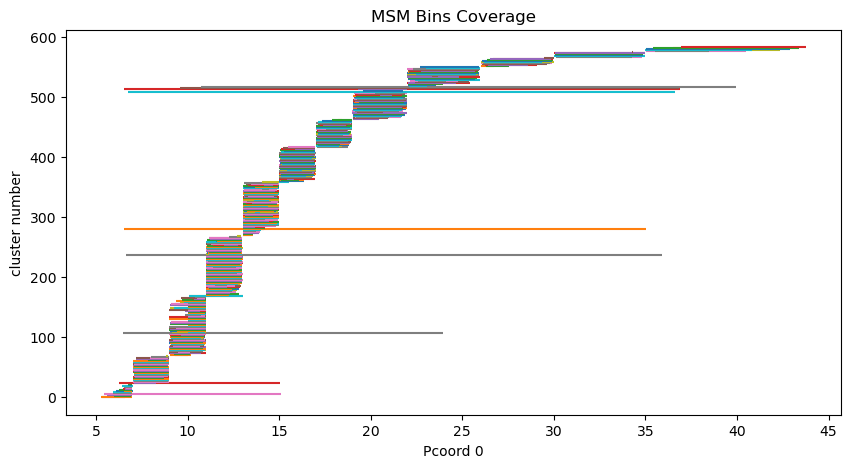

In [36]:
plot_clusters(0)

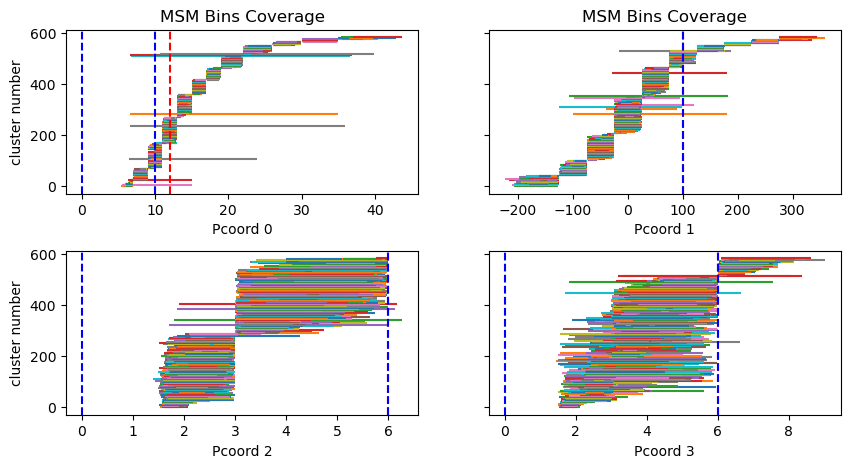

In [37]:
# making a 4 panel plot for each pcoord dim
fig, ax = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(10,5))
for i, panel in enumerate(ax.reshape(-1)):
    plot_clusters(i, panel)
    model.draw_basis_target_boundaries(panel, i)
ax[0,1].set_ylabel("")
ax[1,1].set_ylabel("")
ax[1,0].set_title("")
ax[1,1].set_title("")
plt.subplots_adjust(hspace=0.35)

Had to adjust `_plotting.py` before `plot_flux` worked:
``` Python
322             binCenters[_model.indTargets] = _model.target_bin_centers[pcoord_to_use]
323             binCenters[_model.indBasis] = _model.basis_bin_centers[pcoord_to_use]
```

[06/20/23 16:15:32] CRITICAL No cross-validation models have been generated! Do this before making ]8;id=516874;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=217528;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py#279\279]8;;\
                             plots.                                                                                

                    INFO     Fluxes have not yet been generated for main_model, generating now.    ]8;id=628270;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=615713;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py#311\311]8;;\

                    WARNING  Assuming fluxes should be sorted by pcoord dimension 0 -- this is     ]8;id=134619;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=591404;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#402\402]8;;\
                             currently built in to the code.                                                       

[06/20/23 16:15:52] WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=546008;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=439246;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#461\461]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=558566;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=448161;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py#421\421]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

<Axes: xlabel='Pcoord 1', ylabel='Flux (weight/second)'>

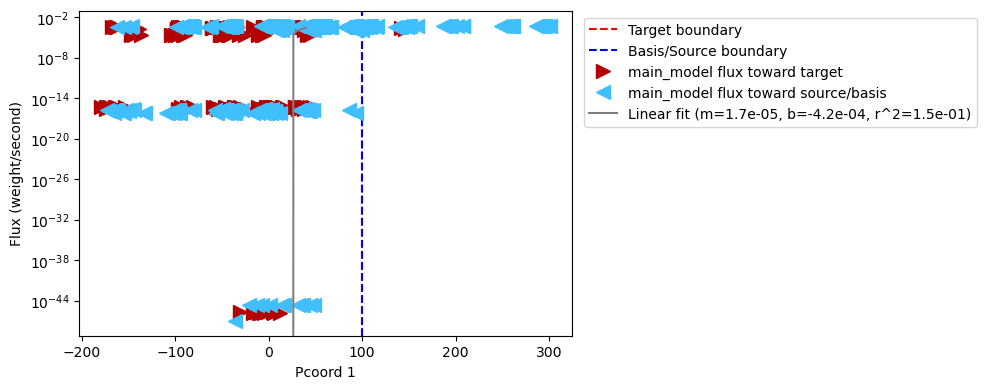

In [38]:
model.plot_flux(suppress_validation=True, pcoord_to_use=1)

[06/20/23 16:15:53] CRITICAL No cross-validation models have been generated! Do this before making ]8;id=809454;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=979283;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py#279\279]8;;\
                             plots.                                                                                

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=737093;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=998593;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py#421\421]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

                    CRITICAL No cross-validation models have been generated! Do this before making ]8;id=594481;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=289381;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py#279\279]8;;\
                             plots.                                                                                

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=837516;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=118154;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py#421\421]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

                    CRITICAL No cross-validation models have been generated! Do this before making ]8;id=564413;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=204031;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py#279\279]8;;\
                             plots.                                                                                

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=504599;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=668109;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py#421\421]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

                    CRITICAL No cross-validation models have been generated! Do this before making ]8;id=329935;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=649917;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py#279\279]8;;\
                             plots.                                                                                

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=791664;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=668519;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py#421\421]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

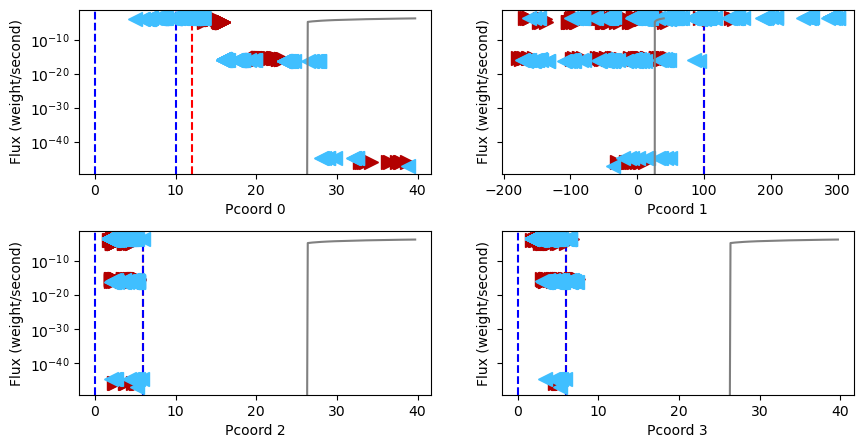

In [39]:
# making a 4 panel flux vs pcoord plot for each pcoord dim
fig, ax = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(10,5))
for i, panel in enumerate(ax.reshape(-1)):
    model.plot_flux(suppress_validation=True, pcoord_to_use=i, ax=panel)
    
plt.subplots_adjust(hspace=0.35)

In [40]:
model.get_committor()

[06/20/23 16:15:54] INFO     Note that, if steady-state weighted ensemble data is being analyzed,  ]8;id=449847;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=177126;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#641\641]8;;\
                             this is a 'pseudocommittor' and not a true committor as a result of                   
                             being constructed from a one-way ensemble.                                            

  0%|          | 0/5.0 [00:00<?, ?it/s]

In [41]:
# optionally could adjust this cluster class attribute for pcoord to use (default=0)
model.pcoord_to_use = 0

[06/20/23 16:16:12] INFO     Note that, if steady-state weighted ensemble data is being analyzed,  ]8;id=43577;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=615407;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#641\641]8;;\
                             this is a 'pseudocommittor' and not a true committor as a result of                   
                             being constructed from a one-way ensemble.                                            

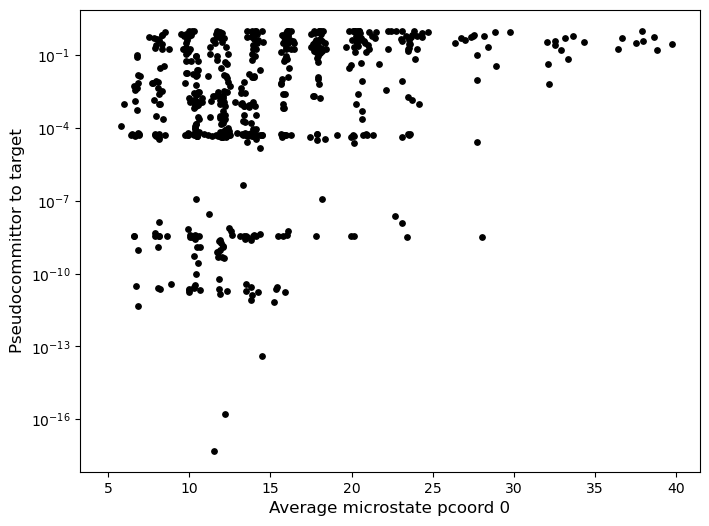

In [42]:
model.plot_committor()

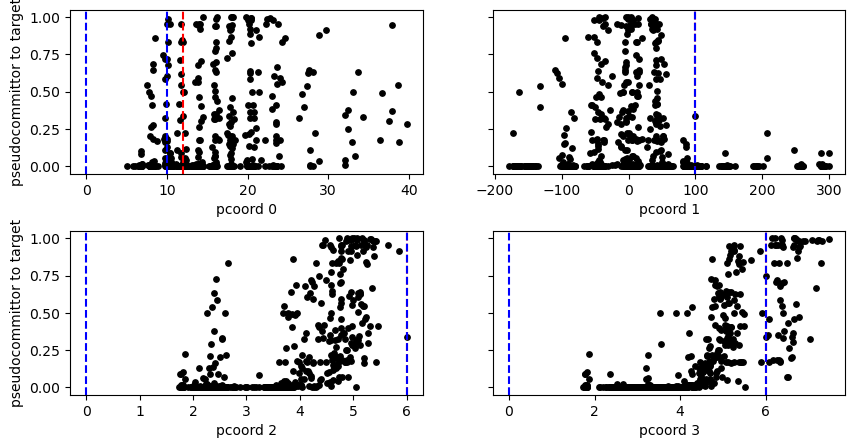

In [43]:
# making a 4 panel committor plot for each pcoord dim
fig, ax = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(10,5))
for i, panel in enumerate(ax.reshape(-1)):
    panel.scatter(model.targetRMSD_centers[:,i], model.q, s=15, c='k')
    panel.set_xlabel(f"pcoord {i}")
    model.draw_basis_target_boundaries(panel, i)
ax[0,0].set_ylabel("pseudocommittor to target")
ax[1,0].set_ylabel("pseudocommittor to target")
fig.subplots_adjust(hspace=0.35)
#plt.yscale('log')

In [44]:
# first 3 center datapoints using all pcoord dims
model.targetRMSD_centers[:3,:]

array([[ 14.48430023, 145.39707947,   1.73011932,   1.74151917],
       [ 11.54144712, 300.07113401,   1.76622424,   1.76897746],
       [ 11.71268617, 300.56103133,   1.76199568,   1.77093256]])

In [45]:
# q is committor array per cluster
model.q.shape

(586,)

[06/20/23 16:17:58] CRITICAL No cross-validation models have been generated! Do this before making ]8;id=775755;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=377912;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py#118\118]8;;\
                             plots.                                                                                

[06/20/23 16:17:59] INFO     Note that, if steady-state weighted ensemble data is being analyzed,  ]8;id=328959;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=732730;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#641\641]8;;\
                             this is a 'pseudocommittor' and not a true committor as a result of                   
                             being constructed from a one-way ensemble.                                            

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=542059;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=564115;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py#421\421]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

<Axes: xlabel='Pseudocommittor', ylabel='Flux (weight/second)'>

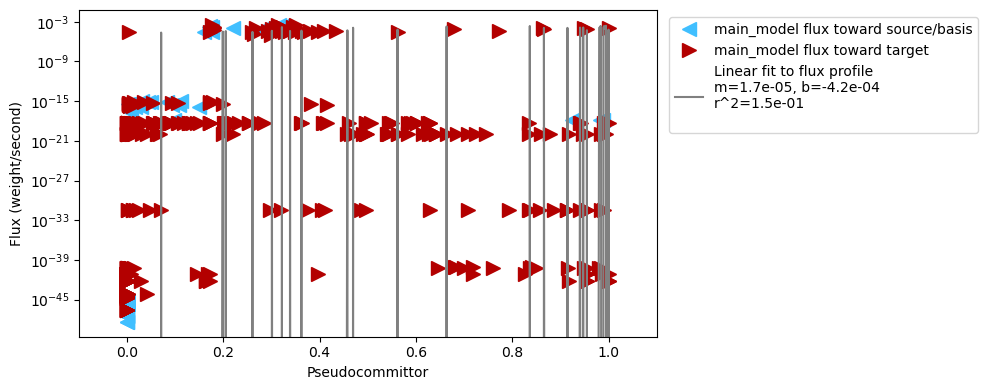

In [50]:
model.plot_flux_committor(suppress_validation=True)
#plt.gca().set_yscale('linear')
#plt.savefig('flux_pseudo_uneven_bin-restart34-t2-c18.png')

In [8]:
# For loading the clustered model data
from pickle import load
with open(f'{model_name}_400-580_4Dmap_postvalidation.pickle', 'rb') as f:
    model = load(f)

In [47]:
# For saving the clustered model data
from pickle import dump
with open(f'{model_name}_400-580_4Dmap_postvalidation.pickle', 'wb') as f:
    dump(model, f)

### Post-featurization Steps: Block Validation
---

In [51]:
model.do_block_validation(cross_validation_groups=2, cross_validation_blocks=8, use_ray=True)

Output()

[06/20/23 17:03:50] INFO     Beginning analysis of cross-validation group 1/2.                        ]8;id=16054;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:]8;id=301337;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/msm_we.py#962\962]8;;\

[06/20/23 17:11:05] INFO     Started with 7800 clusters, and removed 7401                       ]8;id=875007;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=428882;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1050\1050]8;;\

                    WARNING  All clusters were cleaned from bins {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ]8;id=887494;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=892633;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1067\1067]8;;\
                             10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,                       
                             26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,                       
                             42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,                       
                             58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,                       
                             74, 75, 76, 77, 78, 79, 81, 82, 83, 85, 86, 87, 88, 89, 91, 92,                       
                             93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106,                        
                             107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,                      
                             120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,                      
                             133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 145, 147, 148,                      
                             149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,                      
                             163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,                      
                             176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 187, 188, 189,                      
                             190, 191, 193, 195, 196, 197, 199, 201, 202, 203, 205, 208, 209,                      
                             211, 213, 214, 215, 217, 218, 219, 220, 221, 223, 224, 225, 226,                      
                             227, 229, 230, 231, 232, 233, 235, 236, 237, 238, 239, 241, 243,                      
                             244, 245, 247, 249, 250, 251, 253, 255, 256, 257, 259, 261, 262,                      
                             263, 265, 267, 268, 269, 271, 272, 273, 274, 275, 277, 278, 279,                      
                             280, 281, 283, 284, 285, 286, 287, 289, 290, 291, 292, 293, 295,                      
                             296, 297, 298, 299, 301, 303, 304, 305, 307, 309, 310, 311, 313,                      
                             316, 317, 319, 322, 323, 325, 328, 329, 331, 332, 333, 334, 335,                      
                             337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349,                      
                             350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 361, 363, 364,                      
                             365, 367, 369, 370, 371, 373, 376, 377, 379, 382, 383, 385, 388,                      
                             389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401,                      
                             402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414,                      
                             415, 416, 417, 418, 419, 421, 422, 423, 424, 425, 427, 429, 430,                      
                             431, 433, 436, 437, 439, 442, 443, 444, 445, 448, 449, 450, 451,                      
                             453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,                      
                             466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,                      
                             479, 480, 481, 482, 483, 484, 485, 486, 487, 489, 490, 491, 492,                      
                             493, 496, 497, 499, 502, 503, 505, 508, 509, 510, 511, 512, 513,                      
                             514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526,            

[06/20/23 18:17:20] INFO     Note: Sorting bins, assuming that pcoord 0 is meaningful for       ]8;id=600376;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=157540;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1643\1643]8;;\
                             sorting                                                                               

                    INFO     Negative elements in pSS after normalization, attempting to correct   ]8;id=11200;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=935732;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#237\237]8;;\
                             with matrix power method.                                                             

                    WARNING  Power method did NOT obtain semidefinite pSS. Some negative values    ]8;id=142599;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=765390;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#255\255]8;;\
                             remain. This is weird, and you should try to figure out why this is                   
                             happening.                                                                            

                    WARNING  Some negative  elements in pSS... Ignoring, and setting model.pSS     ]8;id=735752;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=368767;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#275\275]8;;\
                             anyways.                                                                              

[06/20/23 18:17:21] INFO                                                                           ]8;id=256626;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=474504;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#179\179]8;;\
                             Flux converged to 4.7195e-28 after 3 iterations of inverse iteration.                 

                    ERROR    Error during block validation!                                           ]8;id=738033;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:]8;id=784316;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/msm_we.py#995\995]8;;\

                    ERROR    Negative elements in pSS                                                 ]8;id=568327;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:]8;id=399754;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/msm_we.py#996\996]8;;\
                             Traceback (most recent call last):                                                    
                               File "/ihome/lchong/dty7/Apps/msm_we/msm_we/msm_we.py", line 985, in                
                             do_block_validation                                                                   
                                 _model.get_steady_state()                                                         
                               File "/ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py", line              
                             187, in get_steady_state                                                              
                                 assert (last_pSS >= 0).all(), "Negative elements in pSS"                          
                             AssertionError: Negative elements in pSS                                              

BlockValidationError: Negative elements in pSS

In [ ]:
# plot again with cross validated model
model.plot_flux_committor()

In [8]:
# For loading the clustered model data
from pickle import load
with open(f'{model_name}_400-580_4Dmap_postblockvalidation.pickle', 'rb') as f:
    model = load(f)

In [ ]:
# For saving the clustered model data
from pickle import dump
with open(f'{model_name}_400-580_4Dmap_postblockvalidation.pickle', 'wb') as f:
    dump(model, f)

#### Quick aside: looking at the theory and code behind $k_{AB}$ calculation

Normalizing `model.fluxMatrix` to get transition matrix, output `model.Tmatrix`.
* row-normalize the flux matrix
* set any states with 0 flux (i.e. sinks) to have 1.0
* set target bins to uniformly recycle into basis bins

In [11]:
model.get_Tmatrix()

First calculate SS probability of microbins based on SS solution of the transition matrix (`model.pSS`). 

These are calculated as the eigenvectors of the transition matrix.

In [12]:
model.get_steady_state_algebraic()

[06/15/23 12:11:28] INFO     Negative elements in pSS after normalization, attempting to correct   ]8;id=623078;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=966892;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#237\237]8;;\
                             with matrix power method.                                                             

                    INFO     Corrected to semidefinite pSS in 176 iterations                       ]8;id=395661;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=933098;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#248\248]8;;\

Calculate sum of target state ss flux ($k_{AB}$) via https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8045600/#FD3 equation 3:

$k_{AB} = Flux(A \rightarrow B;SS) = \sum_{i\notin B, j\in B} p_{i}^{\alpha}T_{ij}^{\alpha}$ (haMSM)

Here, $p^{\alpha}$ is given by `model.pSS` and $T^{\alpha}$ is given by `model.Tmatrix`.

Running `model.get_steady_state_target_flux()` calculates $k_{AB}$, output `model.JtargetSS`.

In [13]:
model.get_steady_state_target_flux()

In [14]:
model.JtargetSS

1.9954185219363416e-21

#### Block validation rates

In [ ]:
for i in range(len(model.validation_models)):
    model.validation_models[i].get_steady_state_target_flux()

    print(f'Steady-state target rate is {model.validation_models[i].JtargetSS:.2e} for model {i}')

In [ ]:
list_of_rates = [model.JtargetSS, model.validation_models[0].JtargetSS, model.validation_models[1].JtargetSS]
print(np.std(list_of_rates))
print(np.average(list_of_rates))

### Getting model outputs
---

Block validation output

In [ ]:
import weight_loop
for idx, v_model in enumerate(model.validation_models):
    if idx == 0:
        continue
    weight_loop.create_reweighted_h5_global(v_model,new_name=f'west_{idx}.h5')

Use haMSM weights to create new west.h5 file, use this updated west.h5 file for running subsequent WE simulations.

In [ ]:
import weight_loop

weight_loop.create_reweighted_h5_global(model, west_name='west_nocoords.h5', copy=True, 
                                        struct_filetype='ncrst', new_name=f'west_reweight.h5', 
                                        gen_sstates=True, pdb_out=False, link_out=True, 
                                        link_path="/ocean/projects/mcb180038p/jml230/bdpa_wsh2029_p3_r3",)

Extract transition state (pseudo-committor of a certain range)